<a href="https://colab.research.google.com/github/ArtunKARA/MusicEmotionRecognition/blob/main/LSTM(ner1280_epo500_cross_validation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ortam Kurulumu ve Gerekli Kütüphanelerin Yüklenmesi

In [ ]:
# Gerekli kütüphanelerin yüklenmesi
!pip install librosa
!pip install tensorflow
!pip install scikit-learn

import traceback

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, matthews_corrcoef, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

Verilerin Yüklenmesi ve İşlenmesi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

agresif_muzikler = '/content/drive/My Drive/Music Data/Agresif'
huzunlu_muzikler = '/content/drive/My Drive/Music Data/Hüzünlü'
neseli_muzikler = '/content/drive/My Drive/Music Data/Neşeli'

# Ses dosyalarını ve etiketlerini yükleyin
def load_data(klasor_yolu, label):
    X = []
    y = []
    for dosya in os.listdir(klasor_yolu):
        dosya_yolu = os.path.join(klasor_yolu, dosya)
        data, sample_rate = librosa.load(dosya_yolu)
        mels = librosa.feature.melspectrogram(y=data, sr=sample_rate)
        X.append(mels.T)  # .T ile transpose ederek (time, features) şekline getiriyoruz
        y.append(label)
    return X, y

# Verilerin yüklenmesi
X_agresif, y_agresif = load_data(agresif_muzikler, 'Agresif')
X_huzunlu, y_huzunlu = load_data(huzunlu_muzikler, 'Hüzünlü')
X_neseli, y_neseli = load_data(neseli_muzikler, 'Neşeli')

# Verileri birleştirin
X = X_agresif + X_huzunlu + X_neseli
y = y_agresif + y_huzunlu + y_neseli

# Etiketleri sayısal değerlere dönüştürün
le = LabelEncoder()
y = le.fit_transform(y)

# Pad sequences to have the same length
X_padded = pad_sequences(X, padding='post', dtype='float32')

# NumPy array'e dönüştürün
X_padded = np.array(X_padded)
y = np.array(y)

# Eğitim ve test setlerine ayırın
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1301
  warnings.warn(


Modelin Oluşturulması ve Eğitilmesi

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

# Veri kümenizi K-fold cross validation için hazırlayın
kf = KFold(n_splits=5, shuffle=True)  # 5 parçaya ayırarak shuffle ederek

# Eğitim ve test setleri üzerinde K-fold cross validation yapın
for train_index, test_index in kf.split(X_padded):
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modeli tanımlayın
    model = Sequential()
    model.add(LSTM(1280, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(640))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y)), activation='softmax'))

    # Modeli derleyin
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Early stopping kullanın
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Modeli eğitin
    history = model.fit(X_train, to_categorical(y_train), epochs=50, batch_size=32, validation_data=(X_test, to_categorical(y_test)), callbacks=[early_stopping])


Epoch 1/50
148/148 [==============================] - 59s 363ms/step - loss: 0.8624 - accuracy: 0.6210 - val_loss: 0.6558 - val_accuracy: 0.7318
Epoch 2/50
148/148 [==============================] - 53s 360ms/step - loss: 0.6957 - accuracy: 0.7134 - val_loss: 0.6712 - val_accuracy: 0.7166
Epoch 3/50
148/148 [==============================] - 53s 361ms/step - loss: 0.6426 - accuracy: 0.7390 - val_loss: 0.6184 - val_accuracy: 0.7284
Epoch 4/50
148/148 [==============================] - 53s 360ms/step - loss: 0.6050 - accuracy: 0.7498 - val_loss: 0.6299 - val_accuracy: 0.7318
Epoch 5/50
148/148 [==============================] - 53s 360ms/step - loss: 0.5786 - accuracy: 0.7706 - val_loss: 0.5719 - val_accuracy: 0.7640
Epoch 6/50
148/148 [==============================] - 53s 359ms/step - loss: 0.5912 - accuracy: 0.7661 - val_loss: 0.6908 - val_accuracy: 0.7318
Epoch 7/50
148/148 [==============================] - 53s 359ms/step - loss: 0.5834 - accuracy: 0.7636 - val_loss: 0.5653 - val_ac

Modelin Değerlendirilmesi ve Sonuçların Raporlanması

37/37 [==============================] - 6s 138ms/step
   Accuracy  F1 Score   Recall  Precision   ROC AUC       MCC
0   0.84928  0.849185  0.84928   0.849224  0.956962  0.773868
Confusion Matrix:
[[356  31  17]
 [ 33 327  36]
 [ 24  37 320]]


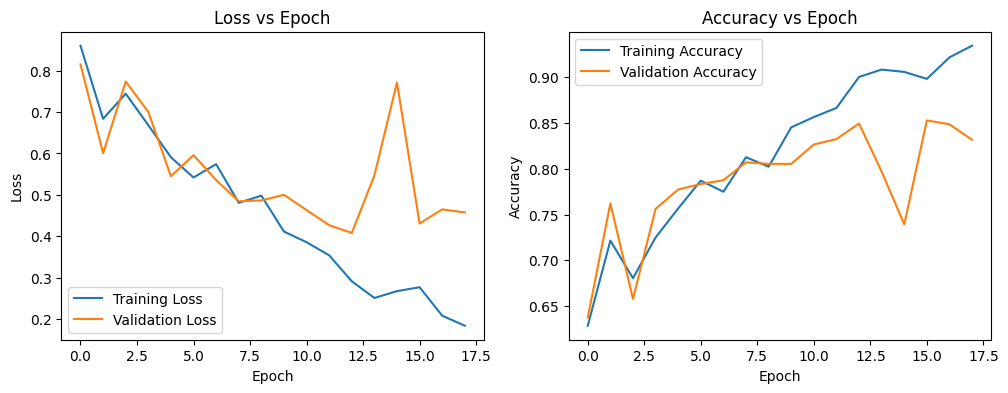

ROC AUC Score (Macro): 0.9569365871499508


In [ ]:
# Model evaluation on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Performance metrics calculation
accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovr')
mcc = matthews_corrcoef(y_test, y_pred_classes)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Results in tabular format
results = pd.DataFrame({
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'Recall': [recall],
    'Precision': [precision],
    'ROC AUC': [roc_auc],
    'MCC': [mcc]
})

print(results)
print('Confusion Matrix:')
print(conf_matrix)

# Training loss and accuracy plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ROC curve plotting for multiclass classification
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
roc_auc = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovr')

# Print the ROC AUC score
print("ROC AUC Score (Macro):", roc_auc)